# LOAN DEFAULT PREDICTION

##### Imoporting Libraries

In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter


In [3]:
# loading the dataset and viewing it
dataset = pd.read_csv("Default_Fin.csv")
dataset

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0
...,...,...,...,...,...
9995,9996,1,8538.72,635908.56,0
9996,9997,1,9095.52,235928.64,0
9997,9998,1,10144.92,703633.92,0
9998,9999,1,18828.12,440029.32,0


In [4]:
dataset.shape # checking the shape of the dataset

(10000, 5)

In [5]:
dataset.describe() # checing the basic statistics of the columns

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,0.705600,10024.498524,402203.782224,0.033300
std,2886.89568,0.455795,5804.579486,160039.674988,0.179428
min,1.00000,0.000000,0.000000,9263.640000,0.000000
25%,2500.75000,0.000000,5780.790000,256085.520000,0.000000
50%,5000.50000,1.000000,9883.620000,414631.740000,0.000000
75%,7500.25000,1.000000,13995.660000,525692.760000,0.000000
max,10000.00000,1.000000,31851.840000,882650.760000,1.000000


In [6]:
dataset.info() # basic information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          10000 non-null  int64  
 1   Employed       10000 non-null  int64  
 2   Bank Balance   10000 non-null  float64
 3   Annual Salary  10000 non-null  float64
 4   Defaulted?     10000 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 390.8 KB


In [7]:
dataset.isna().sum() # check for missing values 

Index            0
Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64

In [8]:
# renaming the Defaulted Column to Default 

dataset = dataset.rename(columns={"Bank Balance":"Bank_balance","Annual Salary": "Annual_salary","Defaulted?": "Defaulted"})
dataset

,Index,Employed,Bank_balance,Annual_salary,Defaulted
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0
...,...,...,...,...,...
9995,9996,1,8538.72,635908.56,0
9996,9997,1,9095.52,235928.64,0
9997,9998,1,10144.92,703633.92,0
9998,9999,1,18828.12,440029.32,0


<p>Plotting count plot for the "Default column"</p>

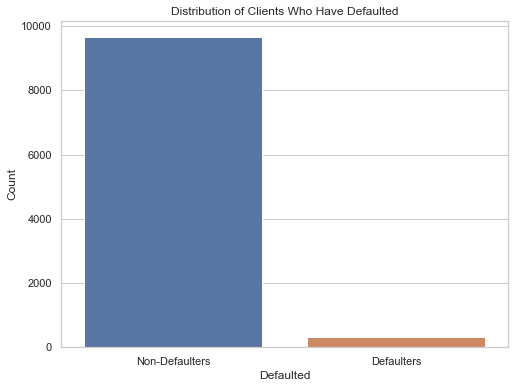

In [9]:
# Create a bar chart using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='Defaulted', data=dataset)

# Set the labels and title
plt.xlabel('Defaulted')
plt.ylabel('Count')
plt.title('Distribution of Clients Who Have Defaulted')
plt.xticks([0,1], ["Non-Defaulters", "Defaulters"])
plt.show()

In [10]:
dataset["Defaulted"].value_counts() # checking the amount of data that belonged for each of  category

0    9667
1     333
Name: Defaulted, dtype: int64

<p>Visualing the Bank Balance and Anual salary column to know if transformation is needed</p>

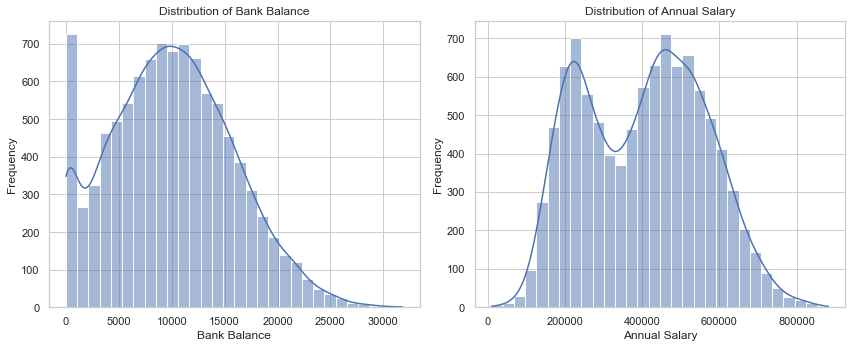

In [11]:
# Plotting the distribution of 'Bank Balance' and 'Annual Salary' using seaborn
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(dataset['Bank_balance'], bins=30, kde=True)
plt.xlabel('Bank Balance')
plt.ylabel('Frequency')
plt.title('Distribution of Bank Balance')

plt.subplot(1, 2, 2)
sns.histplot(dataset['Annual_salary'], bins=30, kde=True)
plt.xlabel('Annual Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Annual Salary')

plt.tight_layout()
plt.show()


<p>Checking the Employed column to know how many employed and unemployed are there in the Employed column</p>

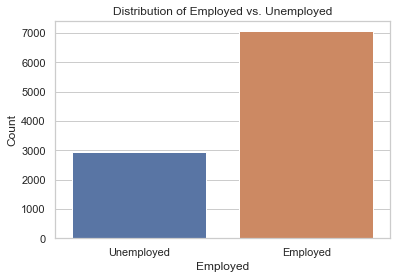

In [12]:
# Plotting the distribution of the 'Employed' column using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x='Employed', data=dataset)
plt.xlabel('Employed')
plt.ylabel('Count')
plt.title('Distribution of Employed vs. Unemployed')
plt.xticks([0, 1], ['Unemployed', 'Employed'])
plt.show()


In [13]:
dataset["Employed"].value_counts() #counting the Employed column, 1 represent employed, 0 represent unemployed

1    7056
0    2944
Name: Employed, dtype: int64

<p>Subsetting the employed column to perform analysis on it</p>

In [14]:
employed = dataset[dataset["Employed"]== 1]
unemployed = dataset[dataset["Employed"]  == 0]


In [15]:
employed.head()

,Index,Employed,Bank_balance,Annual_salary,Defaulted
0,1,1,8754.36,532339.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0
6,7,1,9906.12,298862.76,0


In [16]:
employed['Defaulted'].value_counts() #Counting the number of employed people that defaulted and not defaulted

0    6850
1     206
Name: Defaulted, dtype: int64

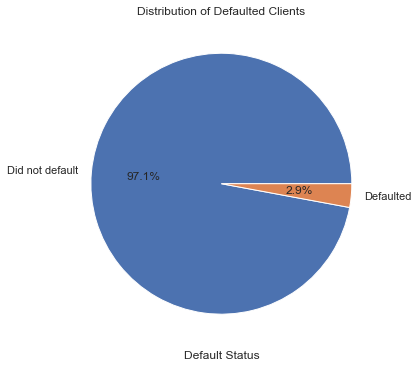

In [17]:
value_counts = employed['Defaulted'].value_counts()

# Plotting the pie chart using Seaborn
plt.figure(figsize=(6, 6))  # Adjust the figure size if needed
plt.title('Distribution of Defaulted Clients')
sns.set_palette('pastel')  # Set color palette
plt.pie(value_counts, labels=['Did not default', 'Defaulted'], autopct='%1.1f%%')
plt.xlabel('Default Status')
plt.show()

In [18]:
unemployed["Defaulted"].value_counts() # Number of unemployed and defaulted and not defaulted

0    2817
1     127
Name: Defaulted, dtype: int64

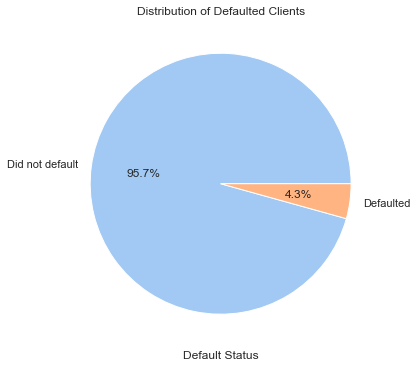

In [19]:
value_counts = unemployed['Defaulted'].value_counts()

# Plotting the pie chart using Seaborn
plt.figure(figsize=(6, 6))  # Adjust the figure size if needed
plt.title('Distribution of Defaulted Clients')
sns.set_palette('pastel')  # Set color palette
plt.pie(value_counts, labels=['Did not default', 'Defaulted'], autopct='%1.1f%%')
plt.xlabel('Default Status')
plt.show()

<p>Checking for correlation</p>

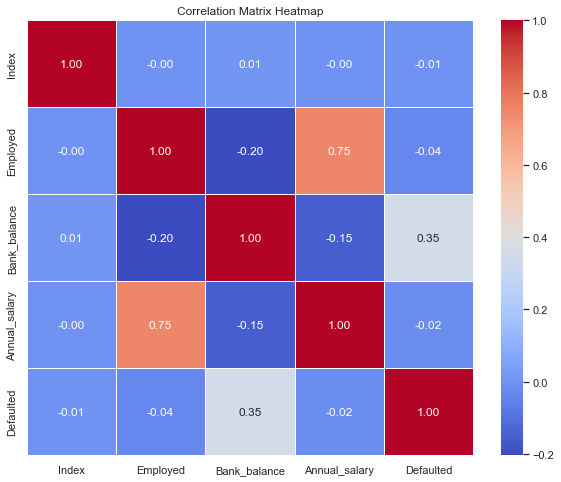

In [20]:
corr_matrix = dataset.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

<p>The correation matrix shows that the Annual Salary and Employed has the highest correlation of 0.75 which is pretty on the high side, but for this project we will not drop it because we have few features</p>

<h6>Variance Inflation Factor (VIF)</h6>
<p>We are performing this to make sure that there is no multicollinearity</p>
<h7>A VIF of >1 < 5 is perfect</h7>

In [21]:
variables = dataset[['Bank_balance', 'Annual_salary']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns

In [22]:
vif

,VIF,Features
0,2.512577,Bank_balance
1,2.512577,Annual_salary


<h3>Note</h3>
<p>As you can see, the dataset is highly imbalanced and this will cause a problem for the ML Algorithm, for this reason i will have to balance the categorical data</p>

In [23]:
X = dataset.iloc[:, 1:-1] # the features or independent variable, you can see that the index column is dropped beacuse it doesn't contribut to the model 
y = dataset.iloc[:, -1]  # The target or dependent variable

In [24]:
X

,Employed,Bank_balance,Annual_salary
0,1,8754.36,532339.56
1,0,9806.16,145273.56
2,1,12882.60,381205.68
3,1,6351.00,428453.88
4,1,9427.92,461562.00
...,...,...,...
9995,1,8538.72,635908.56
9996,1,9095.52,235928.64
9997,1,10144.92,703633.92
9998,1,18828.12,440029.32


In [25]:
y

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: Defaulted, Length: 10000, dtype: int64

<p>Using the Synthetic Minority Oversampling Technique (SMOTE) method to upsample the the minority sample</p>

###### Note that we split before applying SMOTE to afford information Leakage

In [26]:
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



In [27]:
 print(Counter(y_train_resampled)) # checking if the SMOTE worked

Counter({0: 7736, 1: 7736})


#### I will apply some of the classification Algorithm and select the top 1
- Logistic Regression
- Random Forest
- Gradient Boosting
- Support Vector Machine (SVM)
- K-Nearest Neighnors (KNN) 
- Decision Tree

In [28]:
# Initialize and train each model
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    print(f"Evaluating {name}:")
    print(classification_report(y_test, y_pred))
    print("="*50)


Training Logistic Regression...
Evaluating Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1931
           1       0.08      0.80      0.14        69

    accuracy                           0.67      2000
   macro avg       0.53      0.73      0.47      2000
weighted avg       0.96      0.67      0.77      2000

Training Random Forest...
Evaluating Random Forest:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1931
           1       0.22      0.71      0.34        69

    accuracy                           0.91      2000
   macro avg       0.61      0.81      0.65      2000
weighted avg       0.96      0.91      0.93      2000

Training Gradient Boosting...
Evaluating Gradient Boosting:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1931
           1       0.22      0.84      0.35        69

    ac

### Random Forest

In [29]:
# building it fully 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



# Initialize and train the Random Forest classifier on the resampled training data
rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train_resampled, y_train_resampled) # fitting the data into the model

# Make predictions on the original test data (without oversampling)
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's performance on the test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1931
           1       0.22      0.72      0.34        69

    accuracy                           0.90      2000
   macro avg       0.61      0.82      0.64      2000
weighted avg       0.96      0.90      0.93      2000



### Confusion Matrix

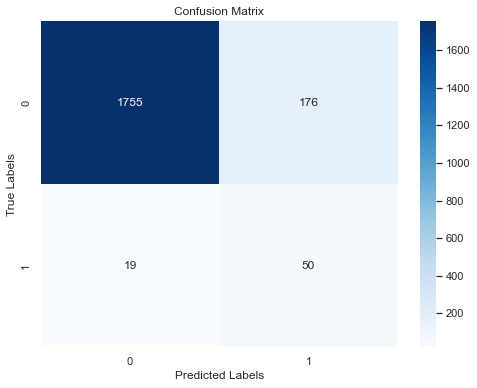

In [30]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


<p>The confusion matrix shows that the Random Forest model correctly predicts 1755 True Positive and 50 True Negatives and 176 False Positive and 19 False Negative overall the model classified 1805 out of 2000 correctly </p>

#### The ROC curve with AUC value

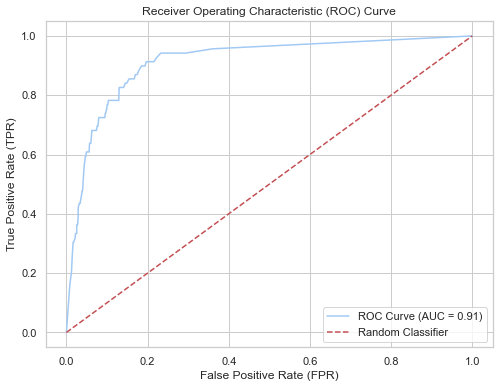

In [31]:
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
print(f"The AUC score is {round(auc_score,3)*100} %") 

The AUC score is 91.2 %


<p>Now we can see that we have a total AUC score of 91.2% which is great! However a few things can be done to improve the model such as scaling the data, downsampling or even using another sampling technique.</p>

<h1>Hope you learnt a thing here!</h1>